## Strandard Import

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

## Explore Data

In [2]:
df_ks = pd.read_csv('KS_train_data.csv', delimiter= ',')
data_ks_to_predict = pd.read_csv('KS_test_data.csv', delimiter= ';')

df_ks_to_display = pd.read_csv('KS_train_data.csv', delimiter= ',')

### Describe Data

In [ ]:
df_ks.describe()

### Data Display


**[goal] => USD_goal**

In [ ]:
df_ks_to_display['usd_goal'] = df_ks_to_display['goal'] *df_ks_to_display['fx_rate']
df_ks_to_display.describe()

### **Calculate Percentage of success**

In [ ]:
df_ks_to_display['pt_success'] = df_ks_to_display['usd_pledged'] / df_ks_to_display['usd_goal']
df_ks_to_display['pt_success'].describe()


**对threshold的选择**
```
> 5 : 3000+
> 10: 1700+
```

In [ ]:
outliers = df_ks_to_display.index[df_ks_to_display['pt_success'] > 5]
outliers

**Typical Extreme case**

```
index = 54553
goal = 1
pledged = 41535
category = game
```

**Kill outliers**

In [ ]:
df_ks_to_display.drop(outliers, inplace=True)

**check new data**

In [ ]:
df_ks_to_display['pt_success'].describe()

**We tried to log化 success rate， but the result is not very pleasantable**

In [ ]:

# df_ks['lgpt_success'] = np.log(df_ks['pt_success'])
# df_ks['lgpt_success'].describe()

### **Calculate Promotion Duration**

In [ ]:
duration_dis = pd.to_datetime(df_ks_to_display['deadline'], unit='s') - pd.to_datetime(df_ks_to_display['launched_at'], unit='s')
# transtate the yyyy-mm-dd format to int
df_ks_to_display['promotion_duration'] = duration_dis / np.timedelta64(1, 'D')

In [ ]:
df_ks_to_display['promotion_duration'].describe()

### **Explore other features**

#### **Category**

In [ ]:
sns.boxplot(df_ks_to_display['pt_success'], df_ks_to_display['category'])

### **Country**

In [ ]:
df_ks_to_display['country'].describe()

**Top 10 countries**

In [ ]:
n = 10
top_10 = df_ks_to_display['country'].value_counts()[:n].index

In [ ]:
print(top_10)

**Select top 10 countries records**

In [ ]:
tops = df_ks_to_display.loc[df_ks_to_display['country'].isin(top_10)]

In [ ]:
print(tops)

**Boxplot**

In [ ]:
sns.boxplot(tops['pt_success'], tops['country'])

### **HeatMap**

**Clear invalid data**

In [ ]:
hm_features = ['backers_count', 'converted_pledged_amount', 'pt_success', 'promotion_duration','usd_goal', 'staff_pick']
nulls = df_ks_to_display[hm_features].isnull().sum()
print(nulls)

In [ ]:
corrmat_all = df_ks_to_display[hm_features].corr()
sns.heatmap(corrmat_all,square=True, annot=True)

## Process Train Dataset

####  Goal convert

In [3]:
df_ks['usd_goal'] = df_ks['goal'] * df_ks['fx_rate']

In [4]:
duration = pd.to_datetime(df_ks['deadline'], unit='s') - pd.to_datetime(df_ks['launched_at'], unit='s')
df_ks['promotion_duration'] = duration / np.timedelta64(1, 'D')

## Text Feature


### **Convert Country code to numeri data**

In [9]:
from sklearn import preprocessing

#creating labelEncoder
le = preprocessing.LabelEncoder()

In [ ]:
# Converting string labels into numbers.
df_ks['country_encoded'] = le.fit_transform(df_ks['country'])
print(df_ks['country_encoded'] )

### **Convert Category code to numeri data**

In [11]:
df_ks['category_encoded'] = le.fit_transform(df_ks['category'])
#print(df_ks['category_encoded'])

### Convert Staff Pick to numerical data

In [12]:
#df_ks['sf_encoded'] = le.fit_transform(df_ks['staff_pick'])

## Blurb & Name Process

### **Convert Blurb into TF-IDF matrix**

Test using TF-IDF to convert text feature into numerical features.

Print blurb information

In [ ]:
print(df_ks.blurb[15])
print(df_ks.funded[15])

Convert `funded` into `0` and `1`

**转化之后反而没有办法来fit model了！！！**

In [ ]:

# data_ks_prep.loc[data_ks_prep.funded == True, 'funded'] = 1
# data_ks_prep.loc[data_ks_prep.funded == False, 'funded'] = 0

In [ ]:
print('invalid funded entries:', df_ks.funded.isnull().sum())

**Test if funded are converted**

In [ ]:
#print(data_ks_prep.funded[15])

### 预处理Blurb


**用空格替换NaN数据**

In [ ]:
#好像不起作用

# data_ks_prep.loc[data_ks_prep.blurb.isnull(), 'funded'] = ' '
# print('invalid Blurb entries:', data_ks_prep.blurb.isnull().sum())
# print(data_ks_prep.loc[data_ks_prep['blurb'].isnull()])

### 对文本进行分词
构建特征字典，将文档转换成特征向量

In [ ]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(data_ks_prep.blurb.values.astype('U'))
X_train_counts.shape

**构建N-gram模型字典**

In [ ]:
count_vect.vocabulary_.get(u'algorithm')

**根据词频算法重构**

In [ ]:
tf_vec = TfidfVectorizer()
X_train_tf = tf_vec.fit_transform(df_ks.blurb.values.astype('U'))
X_train_tf.shape

In [ ]:

# blurbs = data_ks_train['blurb']
# vec = TfidfVectorizer()
# X = vec.fit_transform(blurbs.values.astype('U'))
# pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

#names = data_ks_train['name']
#vec = TfidfVectorizer()
#X2 = vec.fit_transform(names.values.astype('U'))
#pd.DataFrame(X2.toarray(), columns=vec.get_feature_names())


## 拆分为Train Dataset 和 Test Dataset

In [21]:
features = ['usd_goal','promotion_duration','country_encoded','category_encoded','staff_pick']

# 尝试直接使用Country和Category，但是KNN不能fit这种feature
#features = ['usd_goal','promotion_duration','country','category','staff_pick']
#features = ['usd_goal','promotion_duration']
X = df_ks[features]
y = df_ks['funded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

### 测试 to_display dataset 的train Score

In [ ]:
df_ks_to_display['country_encoded'] = le.fit_transform(df_ks_to_display['country'])
df_ks_to_display['category_encoded'] = le.fit_transform(df_ks_to_display['category'])
#df_ks_to_display['staffpick_encoded'] = le.fit_transform(df_ks_to_display['category'])


In [ ]:
features_dis = ['usd_goal','promotion_duration','country_encoded','category_encoded']
X = df_ks_to_display[features_dis]
y = df_ks_to_display['funded']

X_train_dis, X_test_dis, y_train_dis, y_test_dis = train_test_split(X, y, test_size = 0.3)

## 尝试使用贝叶斯来分类

前期准备

In [ ]:
tf_vec = TfidfVectorizer()

train_blurb = tf_vec.fit_transform(df_ks.blurb.values.astype('U'))
test_blurb = tf_vec.fit_transform(df_ks.blurb.values.astype('U'))

In [ ]:
usd_goal = X_train['usd_goal']
promotion_duration = X_train['promotion_duration']
country_encoded = X_train['country_encoded']
category_encoded = X_train['category_encoded']

nb_train_features=list(zip(usd_goal,promotion_duration,country_encoded,category_encoded))

In [ ]:
t_usd_goal = X_test['usd_goal']
t_promotion_duration = X_test['promotion_duration']
t_country_encoded = X_test['country_encoded']
t_category_encoded = X_test['category_encoded']

nb_test_features=list(zip(usd_goal,promotion_duration,country_encoded,category_encoded))

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(nb_train_features,y_train)



In [ ]:
clf.score(nb_train_features, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
clf.score(nb_test_features, y_test)

## KNN Classification

In [22]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)

knn.fit(X_train, y_train)

ValueError: could not convert string to float: 'US'

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=500)

knn.fit(X_train_dis, y_train_dis)

### Predict test target

In [19]:
y_pred = knn.predict(X_test)

In [20]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6612


## Evaluate

### **R Score**

#### **Kth-Neighbour R score comparision Graph**

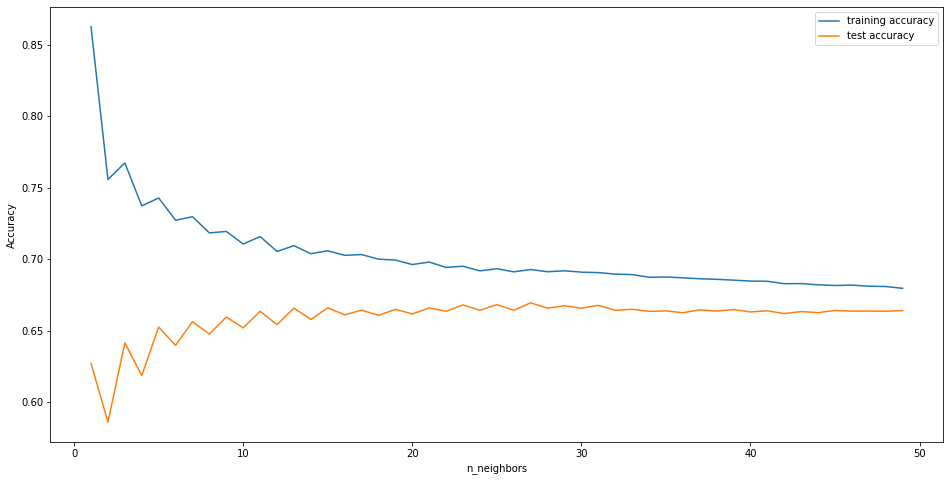

In [14]:
from sklearn.neighbors import KNeighborsClassifier
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 50)
for n_neighbors in neighbors_settings:
 # build the model
 clf = KNeighborsClassifier(n_neighbors=n_neighbors)
 clf.fit(X_train, y_train)
 # record training set accuracy
 training_accuracy.append(clf.score(X_train, y_train))
 # record generalization accuracy
 test_accuracy.append(clf.score(X_test, y_test))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 50)
for n_neighbors in neighbors_settings:
 # build the model
 clf = KNeighborsClassifier(n_neighbors=n_neighbors)
 clf.fit(X_train_dis, y_train_dis)
 # record training set accuracy
 training_accuracy.append(clf.score(X_train_dis, y_train_dis))
 # record generalization accuracy
 test_accuracy.append(clf.score(X_test_dis, y_test_dis))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [ ]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))